# Predicting Healthy Life Expectancy with GDP per Capita Using KNN Regression

### Introduction

#### put intro here !!

In [1]:
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following object is masked from ‘package:tidyr’:

    matches


Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────

 To get started, we first load the `world_happiness.csv` file located in the `data/` folder; assigning it to an object called `happiness`.

In [2]:
happiness <- read_csv("data/world_happiness.csv")
happiness

Parsed with column specification:
cols(
  `Overall rank` = col_double(),
  `Country or region` = col_character(),
  Score = col_double(),
  `GDP per capita` = col_double(),
  `Social support` = col_double(),
  `Healthy life expectancy` = col_double(),
  `Freedom to make life choices` = col_double(),
  Generosity = col_double(),
  `Perceptions of corruption` = col_double()
)



Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Finland,7.769,1.340,1.587,0.986,0.596,0.153,0.393
2,Denmark,7.600,1.383,1.573,0.996,0.592,0.252,0.410
3,Norway,7.554,1.488,1.582,1.028,0.603,0.271,0.341
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
154,Afghanistan,3.203,0.350,0.517,0.361,0.000,0.158,0.025
155,Central African Republic,3.083,0.026,0.000,0.105,0.225,0.235,0.035
156,South Sudan,2.853,0.306,0.575,0.295,0.010,0.202,0.091


Since the column names contain spaces, it will be difficult to use the tidyverse functions. We use the `make.names` function which will replace all the spaces with a `.` so we don't have this problem. The `colnames` function is needed to access the data frame's column names.

In [3]:
colnames(happiness) <- make.names(colnames(happiness))
happiness

Overall.rank,Country.or.region,Score,GDP.per.capita,Social.support,Healthy.life.expectancy,Freedom.to.make.life.choices,Generosity,Perceptions.of.corruption
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Finland,7.769,1.340,1.587,0.986,0.596,0.153,0.393
2,Denmark,7.600,1.383,1.573,0.996,0.592,0.252,0.410
3,Norway,7.554,1.488,1.582,1.028,0.603,0.271,0.341
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
154,Afghanistan,3.203,0.350,0.517,0.361,0.000,0.158,0.025
155,Central African Republic,3.083,0.026,0.000,0.105,0.225,0.235,0.035
156,South Sudan,2.853,0.306,0.575,0.295,0.010,0.202,0.091


Since we are interested in predicting the healthy life expectancy given GDP per capita, we can select the columns `GDP.per.capita` and `Healthy.life.expectancy` in order to clean up our data.

In [4]:
clean_happiness <- happiness %>%
    select(GDP.per.capita, Healthy.life.expectancy)
clean_happiness

GDP.per.capita,Healthy.life.expectancy
<dbl>,<dbl>
1.340,0.986
1.383,0.996
1.488,1.028
⋮,⋮
0.350,0.361
0.026,0.105
0.306,0.295


We want to predict healthy life expectancy (`Healthy.life.expectancy`) given a particular value of GDP per capita (`GDP.per.capita`). To assess the relationship between these two variables, we will plot a scatterplot. Putting `Healthy.life.expectancy` on the y-axis and `GDP.per.capita` on the x-axis.

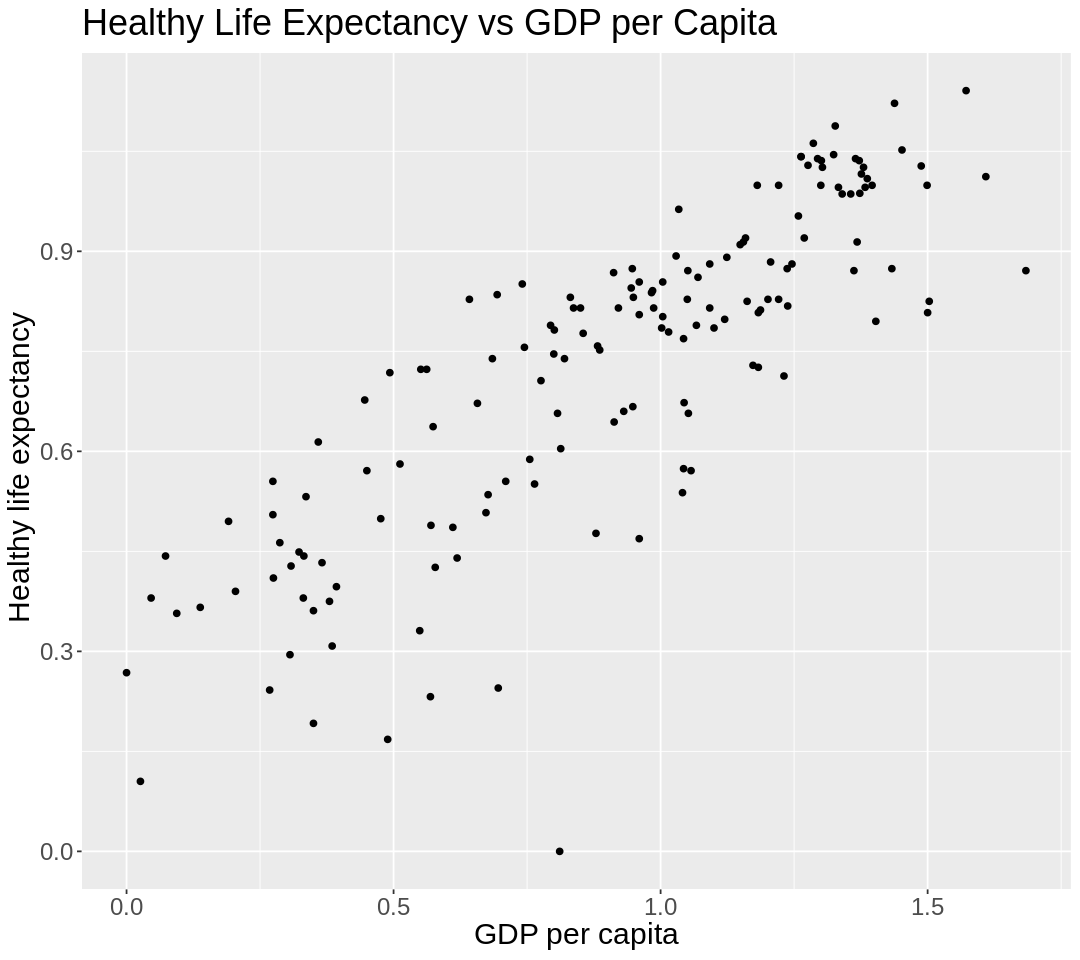

In [5]:
options(repr.plot.width = 9, repr.plot.height = 8)

gdp_hle_plot <- clean_happiness %>%
    ggplot(aes(x = GDP.per.capita, y = Healthy.life.expectancy)) +
    geom_point() +
    labs(x = "GDP per capita", 
         y = " Healthy life expectancy",
         title = "Healthy Life Expectancy vs GDP per Capita") +
    theme(text = element_text(size = 18))

gdp_hle_plot

We will perform $k$-nn regression using the `tidymodels` package. To do so, we first need to create the training and testing datasets. 

We are splitting the data using 75% of the `clean_happiness` data as our training set, setting `Healthy.life.expectancy` as the `strata` argument.

In [6]:
set.seed(26)

# splitting the dataset into a training and a testing set, with 75% of the data in the training set and 25% of data in the testing set
happiness_split <- initial_split(clean_happiness, prop = 0.75, strata = Healthy.life.expectancy)
happiness_training <- training(happiness_split)
happiness_testing <- testing(happiness_split)

Next, we will use cross-validation on our training data (`happiness_training`) to choose $k$. In $k$-nn regression, we will use RMSPE to see how well our predictions matched the true labels.

To perform a cross-validation and choose the optimal $k$ we first create a model specification for $k$-nn. We use the $k$-nearest neighbours algorithm, using the `"kknn"` package for the model engine and specifying that we want to use the straight-line distance. Since this is a regression problem, we will use `set_mode("regression")` in the model specification.

Finally, we create a recipe to preprocess our data. The recipe specifies that the response variable is healthy life expectancy (`Healthy.life.expectancy`) and the predictor variable is GDP per capita (`GDP.per.capita`).

In [7]:
happiness_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
      set_engine("kknn") %>%
      set_mode("regression")

happiness_recipe <- recipe(Healthy.life.expectancy ~ GDP.per.capita, data = happiness_training) %>%
      step_scale(all_predictors()) %>%
      step_center(all_predictors())

happiness_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          1

Operations:

Scaling for all_predictors()
Centering for all_predictors()

Now, we perform a cross-validation with 5 folds using the `vfold_cv` function. We set the strata argument to be `Healthy.life.expectancy`.

Then, we use the `workflow` function to combine our model specification and recipe.

In [8]:
happiness_vfold <- vfold_cv(happiness_training, v = 5, strata = Healthy.life.expectancy)

happiness_workflow <- workflow() %>%
    add_recipe(happiness_recipe) %>%
    add_model(happiness_spec)

happiness_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


Now, we will use the RMSPE to find the best setting for $k$ from our workflow by testing 75 values of $k$.

First, we create a tibble with a column called neighbors that contains a sequence of values, 1 to 75. We assign it to an object called `gridvals`.

Then, we tune our workflow such that it tests all the values in `gridvals` and resamples using our cross-validation data set. Finally, we collect the statistics from our model.

In [9]:
gridvals <- tibble(neighbors = seq(from = 1, to = 75))

happiness_results <- happiness_workflow %>%
                   tune_grid(resamples = happiness_vfold, grid = gridvals) %>%
                   collect_metrics()

happiness_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,0.1659504,5,0.01351180,Model01
1,rsq,standard,0.5920400,5,0.07600681,Model01
2,rmse,standard,0.1394255,5,0.01329515,Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
74,rsq,standard,0.6559873,5,0.029454955,Model74
75,rmse,standard,0.1879543,5,0.009528211,Model75
75,rsq,standard,0.6575640,5,0.028663352,Model75


Next, we find the minimum RMSPE along with it's associated metrics such as the mean and standard error, to help us find the number of neighbors that will serve as our best $k$ value.

In [10]:
happiness_min <- happiness_results %>%
   filter(.metric == "rmse") %>%
   arrange(mean, std_err) %>% 
   head(1)

happiness_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
14,rmse,standard,0.1213263,5,0.006653407,Model14


To assess how well our model might do at predicting on unseen data, we assess its RMSPE on the test data. We first re-train our $k$-nn regression model on the entire training data set, using the $K$ value we obtained previously in `happiness_min`.

First, we pull the best `neighbors` value from `happiness_min` and store it an object called `k_min`. 

Following that, we repeat the workflow analysis again but with a brand new model specification with `k_min`. We will reuse `happiness_recipe` for this workflow, as we do not need to change it for this task.

Next, we use the `predict` function to make predictions on the test data, and use the `metrics` function again to compute a summary of the regression's quality.

In [11]:
k_min <- happiness_min %>%
         pull(neighbors) %>%
         as.integer()

happiness_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) %>%
         set_engine("kknn") %>%
         set_mode("regression")

happiness_best_fit <- workflow() %>%
         add_recipe(happiness_recipe) %>%
         add_model(happiness_best_spec) %>%
         fit(data = happiness_training)

happiness_summary <- happiness_best_fit %>%
          predict(happiness_testing) %>%
          bind_cols(happiness_testing) %>%
          metrics(truth = Healthy.life.expectancy, estimate = .pred)

happiness_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.1769596
rsq,standard,0.5574371
mae,standard,0.1217568


Finally, we visualize what the relationship between `GDP.per.capita` and `Healthy.life.expectancy` looks like with our best $k$ value to explore how the $k$ value affects $k$-nn regression.

We use the `predict` function on the workflow analysis that utilizes the best $k$ value (`happiness_best_fit`) to create predictions for the `happiness_training` data. Then, we add the column of predictions to the `happiness_training` data frame.

Next, we create a scatterplot with the GDP per capita against the healthy life expectancy from `hle_preds`.

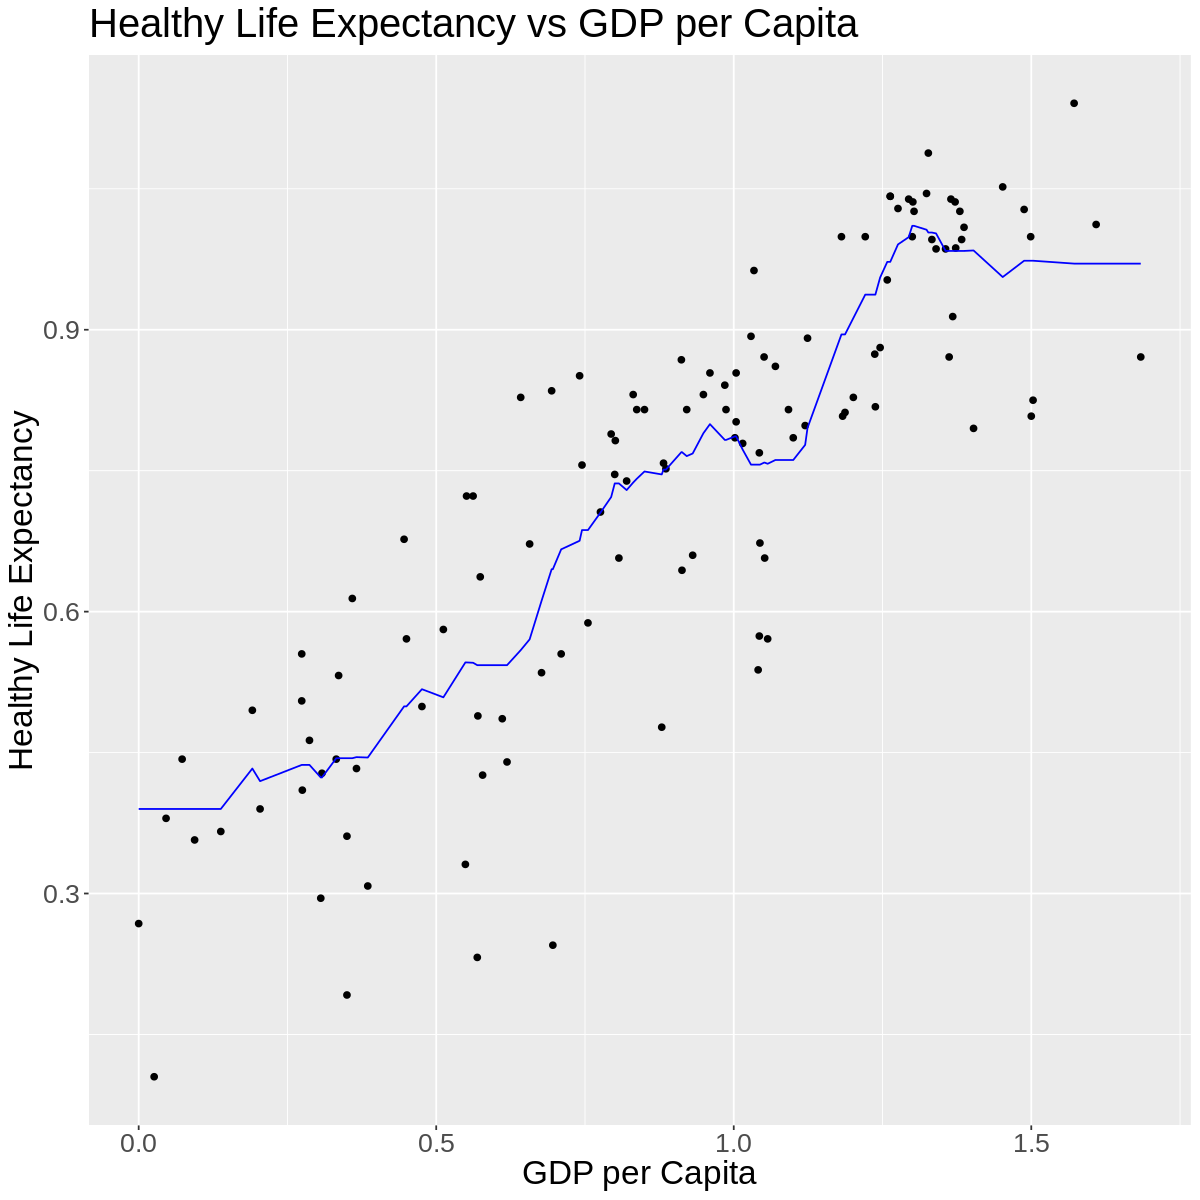

In [12]:
options(repr.plot.width = 10, repr.plot.height = 10)

hle_preds <- predict(happiness_best_fit, happiness_training) %>%
    bind_cols(happiness_training)

happiness_plot <- happiness_training %>%
    ggplot(aes(x = GDP.per.capita, y = Healthy.life.expectancy)) +
    geom_point() +
    geom_line(data = hle_preds, 
              mapping = aes(x = GDP.per.capita, y = .pred),
              color = "blue") +
    labs(x = "GDP per Capita", y = "Healthy Life Expectancy", title = "Healthy Life Expectancy vs GDP per Capita") +
    theme(text = element_text(size = 20))

happiness_plot

### Discussion

### References